<a href="https://colab.research.google.com/github/kevinmcmanus/cas-tau/blob/master/AstropyTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Astropy

## Fancy Plots

### Bunch of Set Up Stuff

In [16]:
!pip install astroquery

In [17]:
# libraries for general data mashing and plotting
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.colors as colors
%matplotlib inline

In [18]:
from astropy.coordinates import Angle, Distance
from astropy.units import Quantity
import astropy.units as u
from astroquery.simbad import Simbad
import astropy.coordinates as coord
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.table import QTable, Table, vstack
from astropy.units import Quantity

### Construct HR-Diagram for the Pleiades with Gaia Data

A first approximation to obtaining the members of the Pleiades open cluster is to execute a cone search of the Gaia Archive using astrometrics from Simbad.
In the case fo the Pleiades, these are:
```
ra = 56.75 degree
dec = 24.1167 degree
parallax = 7.364 mas
pmra = 19.997 mas/year
pmdec = -45.548 mas/year
```

In [19]:
from astroquery.gaia import Gaia

# construct ADL query using astrometrics from above, add some obs quality constraints
job3 = Gaia.launch_job("SELECT source_id, ra, dec, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, parallax \
    FROM gaiadr2.gaia_source \
    WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
    AND abs(pmra_error/pmra)<0.10 \
    AND abs(pmdec_error/pmdec)<0.10 \
    AND pmra IS NOT NULL AND abs(pmra)>0 \
    AND pmdec IS NOT NULL AND abs(pmdec)>0 \
    AND pmra BETWEEN 15 AND 25 \
    AND pmdec BETWEEN -55 AND -40;")
pleiades_table = job3.get_results()

#examine first 10 records
pleiades_table[0:10]

source_id,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax
,deg,deg,mag,mag,mag,mas
int64,float64,float64,float32,float32,float32,float64
65693075278791552,58.45209641024671,23.485778193170404,15.684173,16.8151,14.622672,3.4866299261260667
65674039981117056,57.937676685851116,23.279746731942588,20.107876,20.954243,18.825369,2.406580185988847
65607760048708608,58.10969274598988,23.06037344119279,20.119907,20.536541,18.868631,0.31213309023545693
69877988331531904,55.930095532879015,25.0805015068784,7.4981666,7.581719,7.3928056,8.027063450746246
68585851713901952,55.461602524301505,25.27623121881423,19.361774,21.501656,18.033218,4.548594558832415
64933621980897536,57.17084229066591,23.237979114981755,16.102013,17.91502,14.798337,8.509836138095356
66816187748666624,56.99900482385139,24.731092856679197,12.923352,13.676245,12.085092,6.493298083217951
64884208379713152,57.01650068097936,22.876860506461384,20.06,20.551508,19.022774,0.30017444741805516


In [20]:
#from astropy.coordinates import Distance
#from astropy.units import Quantity
# get distance from parallax
distance = Distance(parallax=Quantity(pleiades_table['parallax']))

#absolute magnitude is the apparent magnitude (phot_g_mean_mag) scaled up to a standard distance of 10pc.  distmod does this
abs_mag=pleiades_table['phot_g_mean_mag'] - distance.distmod
star_color = pleiades_table['phot_bp_mean_mag'] - pleiades_table['phot_rp_mean_mag']

Text(0, 0.5, 'Absolute Magnitude: $m_g - distmod$')

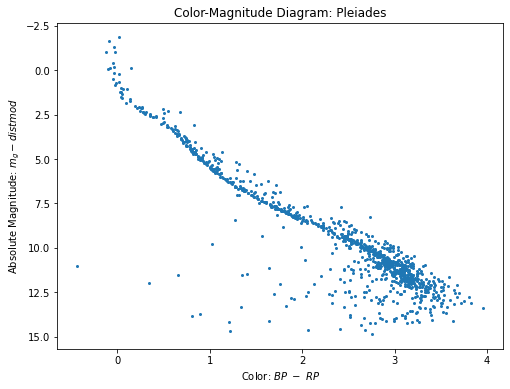

In [21]:
#ready to plot!
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(star_color, abs_mag, s=4)
ax.invert_yaxis()

ax.set_title('Color-Magnitude Diagram: Pleiades')
ax.set_xlabel(r'Color: $BP\ - \ RP$')
ax.set_ylabel(r'Absolute Magnitude: $m_g - distmod$')

### Galactic Hydrogen Plot

#### Fetch the Hydrogen Data

Data from the [HI4PI: A full-sky HI survey based on EBHIS and GASS](https://arxiv.org/abs/1610.06175)

Data File format:
```
Byte-by-byte Description of file: nhi_hpx.dat
--------------------------------------------------------------------------------
   Bytes Format  Units   Label     Explanations
--------------------------------------------------------------------------------
   1-  8  I8     ---     HPX       HPX index (HPXINDEX)
  10- 18  F9.5   deg     RAdeg     Right ascension (J2000)
  20- 28  F9.5   deg     DEdeg     Declination (J2000)
  30- 38  F9.5   deg     GLON      Galactic longitude (J2000)
  40- 48  F9.5   deg     GLAT      Galactic latitude (J2000)
  50- 71  E22.15 cm-2    NHI       HI column density
--------------------------------------------------------------------------------
```

In [22]:
url = 'https://cdsarc.unistra.fr/ftp/J/A+A/594/A116/nhi_hpx.dat.gz'
cols = ['HPX', 'RAdeg','DEdeg','GLON','GLAT', 'NHI']

hi4pi = pd.read_csv(url, delim_whitespace=True, names=cols, header=None)
print(f'hi4pi has {len(hi4pi)} records')


hi4pi has 12582912 records


In [11]:
hi4pi.head()

,HPX,RAdeg,DEdeg,GLON,GLAT,NHI
0,0,192.90971,27.13788,45.0,89.95431,9.174280e+19
1,1,192.84877,27.17301,135.0,89.95431,9.244184e+19
2,2,192.80931,27.11878,225.0,89.95431,9.394214e+19
3,3,192.87024,27.08366,315.0,89.95431,9.281170e+19
4,4,192.96046,27.11176,22.5,89.90863,9.085496e+19


In [ ]:
#don't run this code -- takes 20 minutes
#fig = plt.figure(figsize=(12,12))
#ax = fig.add_subplot(111)
#ax.scatter(hi4pi.RAdeg, hi4pi.DEdeg, c=hi4pi.NHI, cmap='gnuplot')
#ax.invert_xaxis()

#### Crunch the Data Array

In [23]:
#round to 1/10 degree precision
hi4pi['RAdeg1'] = np.round(hi4pi.RAdeg,1)
hi4pi['DEdeg1'] = np.round(hi4pi.DEdeg, 1)
hi4pi['GLAT1'] = np.round(hi4pi.GLAT,1)
hi4pi['GLON1'] = np.round(hi4pi.GLON,1)

#get the mean NHI value at the new precision level, rename the columns to good ol' ra and dec

#equatorial coords
hi4pi_eq = hi4pi[['RAdeg1', 'DEdeg1', 'NHI']].groupby(['RAdeg1','DEdeg1']).mean().reset_index()
hi4pi_eq.rename(columns={"RAdeg1":"ra", "DEdeg1":"dec"}, inplace=True)

#galactic coords
hi4pi_gal = hi4pi[['GLON1', 'GLAT1', 'NHI']].groupby(['GLON1','GLAT1']).mean().reset_index()
hi4pi_gal.rename(columns={"GLON1":"l", "GLAT1":"b"}, inplace=True)

#convert everybody to angles and wrap the longitude
hi4pi_eq.ra = Angle(np.array(hi4pi_eq.ra)*u.degree).wrap_at(180*u.degree)
hi4pi_eq.dec = Angle(np.array(hi4pi_eq.dec)*u.degree)

hi4pi_gal.l = Angle(np.array(hi4pi_gal.l)*u.degree).wrap_at(180*u.degree)
hi4pi_gal.b = Angle(np.array(hi4pi_gal.b)*u.degree)

#create the image arrays
#note declination and lattitude in 'x' (row) positions and ra and longitude in 'y' (column) positions
image_eq = pd.pivot_table(hi4pi_eq,index='dec',columns='ra', values='NHI',aggfunc=np.mean).to_numpy( copy=True)

image_gal = pd.pivot_table(hi4pi_gal,index='b',columns='l', values='NHI',aggfunc=np.mean).to_numpy( copy=True)
image_eq.shape, image_gal.shape


((1801, 3600), (1801, 3600))

In [24]:
# create x and y axis vectors for eq. and gal. coords
ra_vec = Angle(np.linspace(hi4pi_eq.ra.min(), hi4pi_eq.ra.max(), image_eq.shape[1], endpoint=False)*u.degree)
dec_vec= Angle(np.linspace(hi4pi_eq.dec.min(), hi4pi_eq.dec.max(), image_eq.shape[0], endpoint=False)*u.degree)

l_vec = Angle(np.linspace(hi4pi_gal.l.min(), hi4pi_gal.l.max(), image_gal.shape[1], endpoint=False)*u.degree)
b_vec = Angle(np.linspace(hi4pi_gal.b.min(), hi4pi_gal.b.max(), image_gal.shape[0], endpoint=False)*u.degree)

#### Create Plots

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


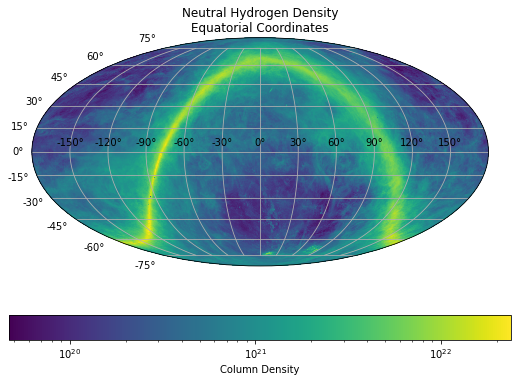

In [27]:
# plot in equatorial coordinates

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='mollweide')
pcm = ax.pcolormesh(ra_vec.radian,
           dec_vec.radian,
           image_eq,
           cmap='viridis', norm=colors.LogNorm())
ax.grid()
ax.set_title('Neutral Hydrogen Density\nEquatorial Coordinates')

plt.colorbar(pcm, orientation='horizontal',label='Column Density')


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


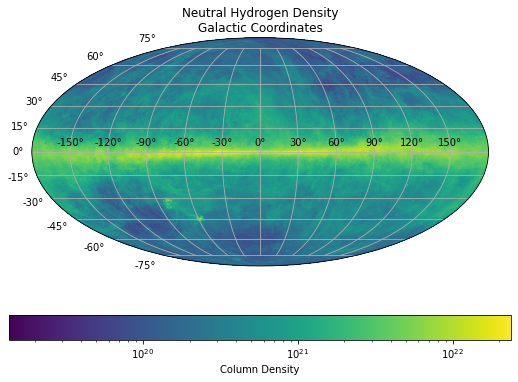

In [26]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='mollweide')
pcm=ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='viridis', norm=colors.LogNorm())
ax.grid()
ax.set_title('Neutral Hydrogen Density\nGalactic Coordinates')

plt.colorbar(pcm, orientation='horizontal',label='Column Density')


Astropy is a collecction of Python libraries for use in Astronomy. Its capabilities are vast.  See these two links for an overview and to get an idea of the capabilities Astropy provides:

[Learn Astropy](http://learn.astropy.org/)

[Astropy Tutorials](http://learn.astropy.org/tutorials.html)

In this tutorial, we'll just scratch surface to give you a hands-on encounter with Astropy. After this tutorial you'll know where to look for more information.

## Basics

To install Astropy on your local machine, execute the following:
```
pip install astropy
```
or if you're using Anaconda to manage your Python environments
```
conda install astropy
```

In the environment provided by Google Colab, astropy is already provided so we don't need to do anything.

The next few sub-sections demonstrate some operations with Constants, Units and Coordinates that the more advanced Astropy modules rely on.

### Constants

Many (most) astronomical calculations involve constants: speed of light, graviational constant, Stefan-Boltzman constant and the like.  Astropy provides many of these, in a module called (what else) `constants`

For a more in-depth discussion of Astropy contants, see: 
[Constants Tutorial](https://docs.astropy.org/en/stable/constants/index.html)

In [ ]:
# need the constants module
import astropy.constants as const

In [ ]:
# Gravitational constant G
const.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [ ]:
print(const.G)

  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018


In [ ]:
#Planck's constant
print (const.h)

  Name   = Planck constant
  Value  = 6.62607015e-34
  Uncertainty  = 0.0
  Unit  = J s
  Reference = CODATA 2018


In [ ]:
#speed of light
const.c

<<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>

In [ ]:
#want G in cgs?
const.G.cgs

<Quantity 6.6743e-08 cm3 / (g s2)>

See [List of Constants](https://docs.astropy.org/en/stable/constants/) for complete list of available constants.

### Units

Units allow us to attach dimensions to scalar and vector quantities. Doing so creates an Astropy `Quantity` object, which among other things allows us to convert among units with relative ease.

In [ ]:
#load up the units module
import astropy.units as u

In [ ]:
u.watt

Unit("W")

In [ ]:
632.3 * u.watt

<Quantity 632.3 W>

In [ ]:
type(632.3), type(u.watt), type(632.3*u.watt)

(float, astropy.units.core.Unit, astropy.units.quantity.Quantity)

In [ ]:
w = 632.3*u.watt

In [ ]:
#what did we get, how to take it apart
type(w), w.value, w.unit

(astropy.units.quantity.Quantity, 632.3, Unit("W"))

### Unit Conversion

We can convert from one set of units to another, say nanometers to Angstroms using the Quantity `to` method, below for the Hydrogen Alpha line at 656.28 nanometers:

In [ ]:
# specify the h_alpha line in nanometers
h_alpha =  656.28*u.nm

In [ ]:
#convert to angrstrom:
h_alpha.to(u.angstrom)

<Quantity 6562.8 Angstrom>

Divide the h_alpha wavelength: ($\lambda$) into the speed of light to get frequency:
nu = const.c/h_alpha

In [ ]:
nu = const.c/h_alpha
nu

<Quantity 456805.72011946 m / (nm s)>

Hmmm, meters per nanometers per second, technically correct, but not very useful. Let's look at this in gigahertz

In [ ]:
nu.to(u.gigahertz)

<Quantity 456805.72011946 GHz>

In [ ]:
#work with angles:
from astropy.coordinates import Angle

In [ ]:
def showdeg(theta:Angle):
  print(f'Theta: {theta.deg} degrees')

In [ ]:
showdeg(Angle(60*u.degree))

Theta: 60.0 degrees


In [ ]:
#specify the angle in milliarcseconds:
showdeg(Angle(3600*1000*u.mas))

Theta: 1.0000000000000002 degrees


Lots lots lots more at [Units Tutorial](https://docs.astropy.org/en/stable/units/).  Especially see the section [Using Astropy.units](https://docs.astropy.org/en/stable/units/#using-astropy-units). Also take a look at: [Working with Angles](https://docs.astropy.org/en/stable/coordinates/angles.html)


## Coordinates

[Coordinates Class](https://docs.astropy.org/en/stable/coordinates/)


[SkyCoords](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html)

In [ ]:
#more astropy libraries
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, EarthLocation

In [ ]:
pleiades = SkyCoord.from_name('pleiades')
pleiades

<SkyCoord (ICRS): (ra, dec) in deg
    (56.75, 24.11666667)>

In [ ]:
#get the right ascension
pleiades.ra

<Longitude 56.75 deg>

Notice that by default, RA comes out in degrees, minutes, seconds. To see H:M:S, convert to string with a format parmeter:

In [ ]:
pleiades.ra.to_string(u.hour)

'3h47m00s'

In [ ]:
#galactic coordinates
pleiades.galactic

<SkyCoord (Galactic): (l, b) in deg
    (166.57066283, -23.52116779)>

## Catalog Query

### Simbad

### Sloan Digital Sky Survey

## Observation Planning

## Read FITS file

Astropy can read and write Flexible Image Transport System (fits) files, both locally and remotely. See [FITS File Handling](https://docs.astropy.org/en/stable/io/fits/).

In this section, we'll open a .psrfits file, a .fits file that follows certain conventions for capturing pulsar data. To do so, we need first to mount a storage device into our Colab server.

### Mount drive with demo fits file

In [28]:
from google.colab import drive, auth
auth.authenticate_user()

In [29]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  23321      0 --:--:-- --:--:-- --:--:-- 23321
OK
37 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,278 kB of archives.
After this operation, 12.8 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.30.0_amd64.deb ...
Unpacking gcsfuse (0.30.0) ...
Setting up gcsfuse (0.30.0) ...


In [31]:
#Mount the drive
!mkdir fits_data
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 society-amateur-radio-astronomers fits_data

Using mount point: /content/fits_data
Opening GCS connection...
Opening bucket...
Mounting file system...
File system has been successfully mounted.


### Pulsar Fits File Exploration

Herein, we shall explore the structure of a *.psrfits* file. This type of file is the result of an observation session on the Greenbank Observatory 20M telescope in **pulsar** mode. Observations using the telescope's other modes produce different kinds (formats) of *.fits* files.

FITS = Flexible Image Transort System

*.psrfits* appear to be *.fits* specially tailored to capture pulsar observations.  The general case *.psrfits* is documented here:

[PSR FITS file documentation](https://www.atnf.csiro.au/research/pulsar/psrfits_definition/PsrfitsDocumentation.html)

In [32]:
from astropy.io import fits
fpath = 'fits_data/B0329+54_pulsar.fits'

pulsar_hdul = fits.open(fpath)
pulsar_hdul.info()

Filename: fits_data/B0329+54_pulsar.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   ()      
  1  SUBINT        1 BinTableHDU     74   1373R x 17C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1024E, 1024E, 4096E, 4096E, 262144B]   


In [33]:
pulsar_hdul[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDRVER  = '3.4             '   / Header version                                 
FITSTYPE= 'PSRFITS '           / FITS definition for pulsar data files          
DATE    = '2019-06-21T12:02:03' / File creation date (YYYY-MM-DDThh:mm:ss UTC)  
OBSERVER= 'kevin.mcmanus_25127' / Observer name(s)                              
PROJID  = 'Skynet_58655_B0329+54klm1_39979' / Project name                      
TELESCOP= 'NRAO20  '           / Telescope name                                 
ANT_X   =          883772.79

In [34]:
hdr1 = pulsar_hdul[1].header
hdr1

XTENSION= 'BINTABLE'           / ***** Subintegration data  *****               
BITPIX  =                    8 / N/A                                            
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =               303180 / width of table in bytes                        
NAXIS2  =                 1373 / Number of rows in table (NSUBINT)              
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   17 / Number of fields per row                       
TTYPE1  = 'TSUBINT '           / Length of subintegration                       
TFORM1  = '1D      '           / Double                                         
TTYPE2  = 'OFFS_SUB'           / Offset from Start of subint centre             
TFORM2  = '1D      '           / Double                                         
TTYPE3  = 'LST_SUB '        

### Read Remote FITS file

In [35]:
#read fits file from Vizier
fits_url = 'https://cdsarc.unistra.fr/viz-bin/nph-Cat/fits.gz?J/A+A/616/A10/tablea1b.dat.gz'
tablea1b = Table.read(fits_url)

In [36]:
tablea1b[0:5]

Source,Cluster,RAdeg,DEdeg,Gmag,plx,e_plx
,,deg,deg,mag,mas,mas
int32,bytes8,float64,float64,float64,float64,float64
1215360,NGC0188,11.62916,84.77862,18.198,0.000,0.000
1275776,NGC0188,12.51558,84.84479,19.199,0.000,0.000
310912,NGC0188,9.11054,85.11362,19.262,0.000,0.000
1118720,NGC0188,10.38709,84.69476,19.873,0.000,0.000
335616,NGC0188,6.11274,85.16839,18.966,0.000,0.000


## For later

In [ ]:
clusters = ['Blanco 1',
 'Collinder 140',
 'Coma Berenices Cluster',
 'Hyades',
 'Pleiades',
 'Praesepe',
 'alpha Per']

In [ ]:
# set up the Simbad query
from astroquery.simbad import Simbad
from astropy.time import Time
mySimbad = Simbad()
mySimbad.add_votable_fields('parallax', 'pm','velocity','typed_id')
mySimbad.get_votable_fields()


In [ ]:
#from astropy.table import Table, vstack
res_table = vstack([mySimbad.query_object(c) for c in clusters],join_type='exact')

In [ ]:
def fix_table(res_table):
  cluster_info=Table(res_table['TYPED_ID', 'PLX_VALUE', 'PLX_PREC','RA', 'RA_PREC', 'DEC', 'DEC_PREC',
                              'PMRA', 'PMDEC', 'RVZ_RADVEL', 'RVZ_ERROR'])

  #gotta be a better way to do this:
  cluster_info['TYPED_ID'] = [c.decode('utf-8') for c in cluster_info['TYPED_ID']]

  #rename the columns to look like Gaia
  cluster_info.rename_column('TYPED_ID','cluster')
  cluster_info.rename_column('PLX_VALUE','parallax')
  cluster_info.rename_column('PLX_PREC', 'parallax_error')
  cluster_info.rename_column('RA', 'ra')
  cluster_info.rename_column('RA_PREC','ra_error')
  cluster_info.rename_column('DEC', 'dec')
  cluster_info.rename_column('DEC_PREC','dec_error')
  cluster_info.rename_column('PMRA', 'pmra')
  cluster_info.rename_column('PMDEC', 'pmdec')
  cluster_info.rename_column('RVZ_RADVEL','radial_velocity')
  cluster_info.rename_column('RVZ_ERROR', 'rv_error')

  #unmask the columns
  cluster_info = cluster_info.filled() 


  #index on the cluster name
  cluster_info.add_index('cluster')

  # coordinates,  note the update to J2015.5 to match with Gaia
  cluster_info['coords'] = \
      SkyCoord(ra = cluster_info['ra'],
          dec = cluster_info['dec'], unit = (u.hour, u.deg),
          obstime = 'J2000',  #simbad returns J2000 coords
          distance = coord.Distance(parallax=Quantity(cluster_info['parallax'])),
          pm_ra_cosdec = cluster_info['pmra'],
          pm_dec = cluster_info['pmdec'],
          radial_velocity = cluster_info['radial_velocity']).apply_space_motion(new_obstime=Time('2015.5',format='decimalyear'))

  return cluster_info

In [ ]:
open_cluster_info=fix_table(res_table)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='mollweide')
ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='viridis', norm=colors.LogNorm())

# plot the clusters
color=iter(plt.cm.rainbow(np.linspace(0,1,len(clusters))))
for c in clusters:
  ax.scatter(open_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, open_cluster_info.loc[c]['coords'].galactic.b.radian, 
    color=next(color), s=50, label=c)
ax.grid()
ax.legend(loc='upper right')

In [ ]:
glob_clusters=['NGC0104', 'NGC0288', 'NGC0362', 'NGC1851', 'NGC5272', 'NGC5904',
       'NGC6205', 'NGC6218', 'NGC6341', 'NGC6397', 'NGC6656', 'NGC6752',
       'NGC6809', 'NGC7099']

In [ ]:
#from astropy.table import Table, vstack
res_table = vstack([mySimbad.query_object(c) for c in glob_clusters],join_type='exact')

In [ ]:
glob_cluster_info = fix_table(res_table)

In [ ]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
fig = plt.figure(figsize=(16,12))

#gs1 = gridspec.GridSpec(1, 2, width_ratios=(1,9))

#main plot axis
#ax = plt.subplot(gs1[0,1], projection='mollweide')
ax = fig.add_subplot(111, projection='mollweide')
pcm = ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='Greys', norm=colors.LogNorm(),alpha=0.3)

# plot the clusters
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in clusters:
  ax.scatter(open_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, open_cluster_info.loc[c]['coords'].galactic.b.radian, 
    marker='P',color=next(color), s=200, label=c, alpha=1.0)
  
# plot the globs
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in glob_clusters:
  ax.scatter(glob_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, glob_cluster_info.loc[c]['coords'].galactic.b.radian, 
    marker='X',color=next(color), s=200, label=c, alpha=1.0)
ax.grid()
ax.legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0.05)
#ax.legend(loc='upper right')
#ax.invert_xaxis()
ax.tick_params(axis='x', colors='white')
ax.set_xlabel('Galactic Longitude', color='White')
ax.set_ylabel('Galactic Latitude', color='white')
#put the colorbar to the left
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("left", size="5%", pad=0.05)
#cax = plt.subplot(gs1[0,0])
cb = plt.colorbar(pcm, ax=[ax], location="left", shrink=0.5)
cb.ax.set_ylabel('log(NHI)')


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
axp = ax.imshow(np.random.randint(0, 100, (100, 100)))
cb = plt.colorbar(axp,ax=[ax],location='left')
plt.show()

In [ ]:
 = ax.imshow(np.arange(100).reshape((10,10)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


In [ ]:
fig = plt.figure(figsize=(12,8))

#axis for main plot
ax = fig.add_subplot(111, projection='mollweide')
pcm = ax.pcolormesh(l_vec.radian,
           b_vec.radian,
           image_gal,
           cmap='viridis', norm=colors.LogNorm(),alpha=0.3)

# plot the clusters
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in clusters:
  ax.scatter(open_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, open_cluster_info.loc[c]['coords'].galactic.b.radian, 
    color=next(color), s=100, label=c)
  
# plot the globs
color=iter(plt.cm.tab20(np.linspace(0,1,20)))
for c in glob_clusters:
  ax.scatter(glob_cluster_info.loc[c]['coords'].galactic.l.wrap_at(180*u.deg).radian, glob_cluster_info.loc[c]['coords'].galactic.b.radian, 
    marker='+',color=next(color), s=100, label=c)
ax.grid()
ax.legend(loc='upper right')

cb = fig.colorbar(pcm, ax=ax)
cb.ax.set_ylabel('log(NHI)',rotation=270)
#ax.invert_xaxis()

In [ ]:
# reduce resolution to 3600 x 1800
rastep = 0.1 # tenth degree steps
decstep = 0.1 # tenth degree steps


In [ ]:
hi4pi['RAint'] = (hi4pi.RAdeg//rastep).astype(int)
hi4pi['DEint'] = ((90+hi4pi.DEdeg)//decstep).astype(int)


In [ ]:
hi4pi.head()

In [ ]:
hi4pi_01 = hi4pi[['RAint','DEint','NHI']].groupby(['DEint','RAint']).mean().reset_index()
hi4pi_image = pd.pivot_table(hi4pi_01,index='DEint',columns='RAint', values='NHI',aggfunc=np.mean).to_numpy( copy=True)

In [ ]:
ra_vec = np.linspace(0,360, 3600,  endpoint=False)
dec_vec= np.linspace(-90,90,1800, endpoint=False)

In [ ]:
decdec, rara = np.meshgrid(dec_vec, ra_vec)

In [ ]:
decdec.shape

In [ ]:
xx=np.arange(10)

In [ ]:
xx[:len(xx)-1]

In [ ]:

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.pcolormesh(ra_vec,dec_vec, hi4pi_image, cmap='gnuplot', norm=colors.LogNorm())
ax.invert_xaxis()

In [ ]:
from astropy.coordinates import Angle
import astropy.units as u

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='mollweide')
#ax.pcolormesh(Angle(ra_vec*u.degree).wrap_at(180*u.degree).radian,
#              Angle(dec_vec*u.degree).radian,
#              hi4pi_image, cmap='gnuplot', norm=colors.LogNorm())
ax.scatter(hi4pi1.RAdeg1, hi4pi1.DEdeg1, c=hi4pi1.NHI, cmap='gnuplot', norm=colors.LogNorm())

#ax.invert_xaxis()

In [ ]:
Angle(90*u.degree).wrap_at('180d').radian

In [ ]:
hi4pi1.head()

In [ ]:
#this takes a while too!
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='mollweide')
ax.scatter(Angle(np.array(hi4pi1.RAdeg1)*u.degree).wrap_at(180*u.degree).radian,
           Angle(np.array(hi4pi1.DEdeg1)*u.degree).radian,
           c=hi4pi1.NHI, cmap='gnuplot', norm=colors.LogNorm())
#ax.invert_xaxis()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
arr = np.random.rand(180, 360)

lon = np.linspace(-np.pi, np.pi,360)
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)

im = ax.pcolormesh(Lon,Lat,arr, cmap=plt.cm.jet)

In [ ]:
plt.plot(Angle(ra_vec*u.degree).radian)